In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
import utilsDIPS as udips
import modelDIPS as mdips

Using TensorFlow backend.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

In [2]:
file_path = '/gpfs/slac/atlas/fs1/d/rafaeltl/public/L1BTag/ml_datasets/ttbar_r11004_RT_ConfigHTT_eff95flat_NewMoU_InIn_sf2_pt4_v1_BTAGSTREAM_gathered.h5'
step_name = 'r11004_RT_ConfigHTT_eff95flat_NewMoU_InIn_sf2_pt4'

In [3]:
dataset = udips.open_dataset(file_path)

jet_E
jet_eta
jet_flav
jet_ip3d_llr
jet_ntrks
jet_phi
jet_pt
jet_weights
trk_chi2
trk_dr
trk_eta
trk_ip3d_d0
trk_ip3d_sig_d0
trk_ip3d_sig_z0
trk_ip3d_z0
trk_phi
trk_pt
trk_ptfrac


In [4]:
training_vars = ["trk_dr", "trk_ptfrac", 
                 "trk_ip3d_sig_d0", "trk_ip3d_sig_z0", 
                 "trk_ip3d_d0", "trk_ip3d_z0"]
# training_vars = ["trk_dr", "trk_ptfrac", "trk_ip3d_sig_d0", "trk_ip3d_sig_z0"]
# training_vars = ["trk_ip3d_sig_d0", "trk_ip3d_sig_z0"]
vars_tolog = ["trk_ptfrac", "trk_dr"]

In [5]:
data_matrix,mean,std = udips.make_data_matrix(dataset,track_vars_to_train=training_vars, 
                                        log_transform_list=vars_tolog, max_tracks=20)

Max number of tracks per jet to train with 20
Total number of jets 862023


In [6]:
# data_matrix = np.zeros_like(unsorted_data_matrix)

In [7]:
# for idm,dm in enumerate(unsorted_data_matrix):
#     sig_d0s = dm[:,2]
#     sorted_indices = np.argsort(sig_d0s)[::-1]
#     data_matrix[idm,:,:] = dm[sorted_indices][:,]

In [8]:
#select only b or light jets
b_or_light_filter, data_matrix_filtered, data_flavor_filtered, data_weight_filtered, data_y_filtered = udips.filter_b_or_light(dataset,data_matrix)

In [9]:
jet_inputs = ["jet_pt", "jet_eta"]
X_jets, X_jets_filtered = udips.make_jet_matrix(dataset, jet_inputs, b_or_light_filter)

In [10]:
## do jet cuts?
do_jet_cuts = True
jet_eta_cut = 2.8
jet_pt_cut = 40000.

ind_pt = dataset["jet_pt"][b_or_light_filter] > jet_pt_cut
ind_eta = np.abs(dataset["jet_eta"])[b_or_light_filter] < jet_eta_cut
sel_index = ind_pt & ind_eta

if do_jet_cuts:
    data_matrix_filtered = data_matrix_filtered[ sel_index , :, : ]
    data_y_filtered = data_y_filtered[sel_index]
    data_weight_filtered = data_weight_filtered[sel_index]
    X_jets_filtered = X_jets_filtered[sel_index]

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test, w_train, w_test, J_train, J_test = train_test_split(
    data_matrix_filtered,
    data_y_filtered,
    data_weight_filtered, 
    X_jets_filtered, 
    test_size=0.30, random_state=42)

In [13]:
do_jet_inputs = True

In [14]:
model = mdips.make_dips_model( [data_matrix_filtered.shape[1], data_matrix_filtered.shape[2]] ,
                              [100], [100], 
                              do_jet_inputs,
                              X_jets_filtered.shape[1])

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
track_inputs (InputLayer)       (None, 20, 6)        0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 20, 6)        0           track_inputs[0][0]               
__________________________________________________________________________________________________
Phi0_Dense (TimeDistributed)    (None, 20, 100)      700         masking_1[0][0]                  
__________________________________________________________________________________________________
sum_1 (Sum)                     (None, 100)          0           Phi0_Dense[0][0]                 
_____________________________________

In [15]:
out_weight=f'dips_test_weight_{step_name}.h5'

In [16]:
model.load_weights(out_weight)

In [17]:
X_testing_total = [J_test, X_test] if do_jet_inputs else X_test
yhat_test = model.predict(X_testing_total, batch_size=2048, verbose=True)

119558/119558 [==============================] - 4s 30us/step


In [18]:
import keras.backend as K

In [19]:
gradients = K.gradients(model.output,model.inputs)

Instructions for updating:
Use tf.cast instead.


In [20]:
input_tensors = model.inputs + [K.learning_phase()]

In [21]:
input_tensors

[<tf.Tensor 'jet_inputs:0' shape=(?, 2) dtype=float64>,
 <tf.Tensor 'track_inputs:0' shape=(?, 20, 6) dtype=float64>,
 <tf.Tensor 'batch_normalization_1/keras_learning_phase:0' shape=() dtype=bool>]

In [22]:
compute_gradients = K.function(inputs=input_tensors, outputs=gradients)

In [23]:
grads = compute_gradients([ J_test, X_test , 0])

In [24]:
grads_jets = grads[0]
grads_tracks = grads[1]

In [25]:
ntrks_X_test = []
for iev in range(X_test[:,:,0].shape[0]):
    ntrks = 1.0*(X_test[iev,:,0] > -99 )
    ntrks_X_test.append( int(ntrks.sum()) )
ntrks_X_test = np.array(ntrks_X_test)

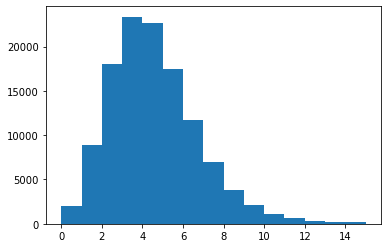

In [26]:
plt.Figure()
plt.hist(ntrks_X_test, bins=15, range=(0,15))
plt.show()

In [27]:
bs_5ts_grads_tracks = grads_tracks[ (y_test==1) & (ntrks_X_test==5)  ][:,:5,:]

In [28]:
ls_5ts_grads_tracks = grads_tracks[ (y_test==0) & (ntrks_X_test==5)  ][:,:5,:]

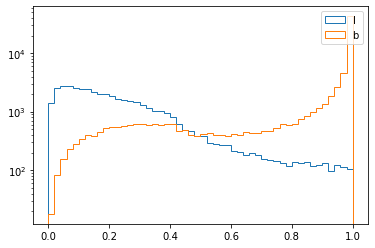

In [29]:
plt.Figure()
plt.hist(yhat_test[y_test==0], histtype='step', range=(0,1), bins=50)
plt.hist(yhat_test[y_test==1], histtype='step', range=(0,1), bins=50)
plt.legend(['l', 'b'])
plt.yscale('log')
plt.show()

In [30]:
def get_my_tracks(ntrks, is_b, tag_disc, is_pass=True):
    ind = (y_test==is_b)
    ind = ind & (ntrks_X_test==ntrks)
    if is_pass:
        ind = ind & (yhat_test.flatten()>tag_disc)
    else:
        ind = ind & (yhat_test.flatten()<tag_disc)
    return grads_tracks[ind,:ntrks,:]

In [31]:
print(y_test.shape, ntrks_X_test.shape, yhat_test.flatten().shape, grads_tracks.shape)

(119558,) (119558,) (119558,) (119558, 20, 6)


In [36]:
def make_sal_plot(arr, title=''):
    var_names_in_original_order = ['trk_dr', 'trk_ptfrac', 
                          'trk_ip3d_sig_d0', 'trk_ip3d_sig_z0', 
                          'trk_ip3d_d0', 'trk_ip3d_z0']
    
    var_names_in_plot_order = [ 'trk_ip3d_sig_d0', 'trk_ip3d_sig_z0', 
                              'trk_ip3d_d0', 'trk_ip3d_z0',
                              'trk_dr', 'trk_ptfrac']
    
    plot_var_names = {
        'trk_dr': r'$\log \Delta$R(trk, jet)', 
        'trk_ptfrac': r'log Track $p_T$/Jet $p_T$', 
        'trk_ip3d_sig_d0': r'$\mathcal{S}_{d_0}$', 
        'trk_ip3d_sig_z0': r'$\mathcal{S}_{z_0\sin\theta}$', 
        'trk_ip3d_d0': r'$d_0$', 
        'trk_ip3d_z0': r'$z_0\sin\theta$'
    }
    
    indices = [ var_names_in_original_order.index(ixx) for ixx in var_names_in_plot_order ]
    my_new_arr = np.array([ arr[:,ix] for ix in indices ])
#     print(my_new_arr)
#     my_new_arr = np.concatenate( my_new_arr, axis=1 )
#     print(my_new_arr)
    
    plt.Figure()
    fig, ax = plt.subplots(1,1)
    pos = ax.imshow(my_new_arr, cmap='RdBu')
    fig.colorbar(pos)
    ax.set_yticklabels(['']+[plot_var_names[ix] for ix in var_names_in_plot_order])
    ax.set_title(title)
    plt.show()

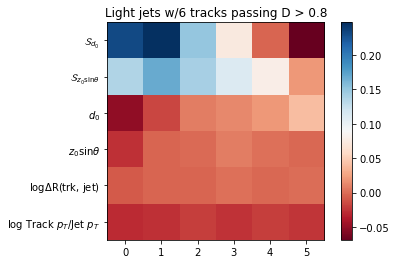

In [37]:
cut_val = 0.8
passed = True
ntrks = 6
is_b = False
title = "b " if is_b else "Light "
title += f"jets w/{ntrks} tracks "
title += "passing " if passed else "failing "
title += f"D > {cut_val}"

make_sal_plot( get_my_tracks(ntrks, is_b, cut_val, passed).mean(0), title )

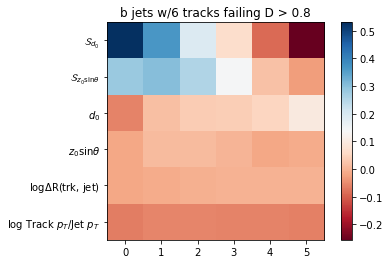

In [38]:
cut_val = 0.8
passed = False
ntrks = 6
is_b = True
title = "b " if is_b else "Light "
title += f"jets w/{ntrks} tracks "
title += "passing " if passed else "failing "
title += f"D > {cut_val}"

make_sal_plot( get_my_tracks(ntrks, is_b, cut_val, passed).mean(0), title )